In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.oriented_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/
Meshcat url:  http://127.0.0.1:7019/static/


In [3]:
# Draw a random sample from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = OrientedClusterRoot,
    root_node_tf = torch.eye(4)
)
torch.random.manual_seed(5)
tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d clusters and %d boxes." % 
      (len(tree.find_nodes_by_type(OrientedCluster)),
       len(tree.find_nodes_by_type(LongBox))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

[2021-10-13 01:35:54.232] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Sampled scene with 2 clusters and 6 boxes.
Sampled tree has score 5.735401


Super tree has 19 nodes


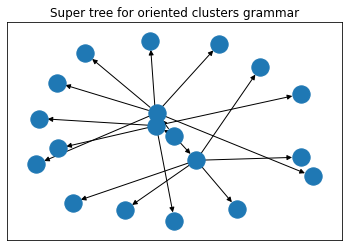

In [4]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [5]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True, max_scene_extent_in_any_dir=5.
)
mip_optimized_tree = get_optimized_tree_from_mip_results(inference_results)
draw_scene_tree_contents_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip")
draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_scene_tree")

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.


Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  1.0767629146575928
Num vars:  8249
Num constraints:  20444


Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Oct 13 01:35:55 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 13450 rows, 8249 columns and 115650 nonzeros
Model fingerprint: 0x4fb27846
Model has 54 quadratic objective terms
Variable types: 7806 continuous, 443 integer (443 binary)
Coefficient statistics:
  Matrix range     [7e-03, 1e+01]
  Objective range  [2e-18, 1e+02]
  QObjective range [1e+00, 1e+02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 5006 rows and 192 columns
Presolve time: 0.22s
Presolved: 8444 rows, 8057 columns, 86545 nonzeros
Presolved model has 54 quadratic objective terms
Variable types: 7629 continuous, 428 integer (428 binary)

Root relaxation: objective -1.436672e+03, 12467 iterations, 0.63 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

In [6]:
# Do NLP refinement of tree
refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=False)
refined_tree = refinement_results.refined_tree
draw_scene_tree_contents_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined_scene_tree")

In [7]:
try:
    mip_optimized_tree.score()
except ValueError as e:
    print("MIP optimized tree wasn't happy, as expected: %s" % str(e))

print("Refined tree score: ", refined_tree.score())
print("Original tree score: ", tree.score())

Refined tree score:  tensor([-96.4205])
Original tree score:  tensor([5.7354])


In [8]:
# Now try to do MCMC on the parsed tree
sampled_trees = do_fixed_structure_mcmc(grammar, tree, num_samples=100, verbose=True)

NotImplementedError: <spatial_scene_grammars.rules.ParentFrameGaussianOffsetRule object at 0x7fe40857c668>

In [ ]:
for sample_k, sampled_tree in enumerate(sampled_trees[::5]):
    draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="sampled/%d" % sample_k)